## Connect and Setup Tango

In [34]:
import os
import logging
import decimal
from tango import DeviceProxy, EventType

LOG_LEVEL = logging.INFO
logging.basicConfig(level=LOG_LEVEL)
logger = logging.getLogger("spectana_demo")

def eng_number(val, unit = "") -> str:
    """
    Convert number to engineering format.

    :param val: input value
    :param val: unit added to end of string

    :returns: formatted string
    """
    f_str = decimal.Decimal(f"{val:.4E}").normalize().to_eng_string()
    f_str = f_str.replace("E-12", "p")
    f_str = f_str.replace("E-9", "n")
    f_str = f_str.replace("E-6", "u")
    f_str = f_str.replace("E-3", "m")
    f_str = f_str.replace("E+3", "k")
    f_str = f_str.replace("E+6", "M")
    f_str = f_str.replace("E+9", "G")
    f_str = f_str.replace("E+12", "T")
    f_str += unit
    return f_str


TANGO_HOST = None

In [35]:
TANGO_HOST = os.environ["TANGO_HOST"]
print(TANGO_HOST)
# os.environ["TANGO_HOST"] = f"{DATABASEDS_NAME}.{KUBE_NAMESPACE}.svc.cluster.local:10000"

127.0.0.1:10000


In [1]:
# specify here the namespace to connect in this cluster
KUBE_NAMESPACE = "integration-itf"
# set the name of the databaseds service
DATABASEDS_NAME = "tango-databaseds"
# set the TANGO_HOST
# os.environ["TANGO_HOST"] = "10.164.10.8:10000"
os.environ["TANGO_HOST"] = f"{DATABASEDS_NAME}.{KUBE_NAMESPACE}.svc.cluster.local:10000"

In [36]:
print(TANGO_HOST)

127.0.0.1:10000


## Connect to Signal Generator

In [37]:
if TANGO_HOST is None:
    siggen_dev = "tango://127.0.0.1:45451/mid-itf/siggen/1#dbase=no"
else:
    siggen_dev = "mid-itf/siggen/1"
print(f"Connect to {siggen_dev}")
siggen = DeviceProxy(siggen_dev)

# Query admin mode
print(f"admin mode : {siggen.adminmode}")

# python_error

Connect to mid-itf/siggen/1
admin mode : 0


In [38]:
# Set admin mode 0 = ON, 1 = OFF
siggen.adminmode = 0
print(f"admin mode : {siggen.adminmode}")

admin mode : 0


In [39]:
print(f"power_dbm : {siggen.power_dbm}")
print(f"frequency : {siggen.frequency}")

power_dbm : -10.0
frequency : 1500000000.0


In [40]:
siggen.power_dbm = -10
siggen.frequency = 1.5e9
print(f"power_dbm : {siggen.power_dbm}")
print(f"frequency : {siggen.frequency}")

power_dbm : -10.0
frequency : 1500000000.0


## Configure Spectrum Analyser

In [41]:
if TANGO_HOST is None:
    spectana_dev = "tango://127.0.0.1:45450/mid-itf/spectana/1#dbase=no"
else:
    spectana_dev = "mid-itf/spectana/1"
print(f"Connect to {spectana_dev}")
spectana = DeviceProxy(spectana_dev)
spectana.set_timeout_millis(5000)
print(f"admin mode : {spectana.adminmode}")
#python_error

Connect to mid-itf/spectana/1
admin mode : False


In [42]:
spectana.adminmode = 0
print(f"admin mode : {spectana.adminmode}")

admin mode : False


In [43]:
spectana.attenuation = 10
spectana.frequency_start = 1000000000
spectana.frequency_stop = 5000000000

In [25]:
print(f"attenuation     : {spectana.attenuation}")
print(f"frequency_start : {spectana.frequency_start}")
print(f"frequency_stop  : {spectana.frequency_stop}")

attenuation     : 10
frequency_start : 1000000000
frequency_stop  : 5000000000


## Read Spectrum Analyser data

In [44]:
from ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu import (
    TRACE1_DATA_FILE,
    make_trace,
)

logger.setLevel(logging.INFO)

trace1 = make_trace(
        siggen.power_dbm,
        siggen.frequency,
        spectana.sweep_points,
        spectana.frequency_start,
        spectana.frequency_stop,
    )
out_file = TRACE1_DATA_FILE
print("Write file %s" % out_file)
with open(out_file, "w") as trc_file:
    trc_file.write(trace1)

spectana.trace1

DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu:Signal frequencies [1500000000.0, 3000000000.0, 4500000000.0]
DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu:Signal amplitudes [-10.0, -55.0, -70.0]
DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu:Frequency from 1GHz to 5GHz, step 6349206.349206 Hz
DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu:     1GHz = -80.20dBm
DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu:1.0063GHz = -80.60dBm
DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu:1.0127GHz = -81.10dBm
DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu: 1.019GHz = -81.80dBm
DEBUG:ska_ser_test_equipment.spectrum_analyser_anritsu.spectrum_analyser_trace_anritsu:1.0254GHz = -81.20dBm
DEBUG:ska_ser_test_equipment.spectrum_an

Write file /tmp/spectana_data.txt


'#43779-80.9,-83.4,-80.2,-80.6,-82.3,-80.4,-81.6,-82.0,-81.5,-81.9,-82.7,-80.6,-83.3,-80.6,-83.6,-82.9,-83.3,-83.9,-84.5,-84.8,-83.2,-83.9,-83.5,-82.2,-81.9,-83.3,-83.1,-84.0,-80.2,-84.1,-80.4,-81.9,-84.9,-83.6,-83.5,-83.9,-80.1,-80.0,-81.8,-81.6,-81.4,-80.4,-81.8,-84.0,-81.6,-82.9,-84.0,-80.3,-84.9,-83.3,-80.1,-80.2,-84.0,-84.6,-83.6,-83.5,-83.9,-84.7,-83.0,-85.0,-84.7,-82.9,-81.5,-81.6,-80.5,-84.2,-83.2,-81.7,-81.9,-83.5,-83.2,-81.5,-84.1,-80.6,-81.7,-81.5,-83.5,-83.5,-10.0,-84.2,-82.9,-80.2,-82.8,-84.3,-84.4,-84.4,-80.0,-80.9,-84.8,-83.1,-82.8,-85.0,-80.3,-83.7,-84.7,-81.2,-84.6,-84.4,-81.7,-84.8,-82.0,-80.8,-82.4,-82.8,-83.7,-82.2,-84.6,-83.6,-83.7,-80.2,-83.7,-81.8,-81.9,-82.5,-81.6,-82.9,-81.7,-83.5,-80.3,-82.0,-82.6,-84.8,-84.9,-80.5,-83.3,-80.7,-83.2,-84.2,-82.4,-80.7,-81.9,-80.0,-82.1,-84.8,-84.1,-80.8,-81.7,-84.9,-81.6,-84.1,-84.2,-80.5,-83.9,-81.5,-85.0,-80.0,-83.0,-84.2,-84.2,-83.4,-82.5,-84.3,-83.6,-82.5,-84.3,-82.6,-81.5,-84.0,-80.4,-84.6,-82.7,-81.2,-80.9,-83.6,-81.1,-82

## Plot Spectrum Analyser data

In [45]:
# Plot data
import decimal
import string
import matplotlib.pyplot

x_points = []
y_points = []
read_buf = spectana.trace1
if read_buf[0] == "#":
    m_len = int(read_buf[1])
    n_len = int(read_buf[2:2+m_len])
    trace_data = read_buf[2+m_len+1:].split(",")
    print("Read %d data items" % len(trace_data))
    f_start = spectana.frequency_start
    f_stop = spectana.frequency_stop
    n_data_len = len(trace_data) - 1
    f_step = (f_stop-f_start)/n_data_len
    print("Frequency step %.2f Hz" % f_step)
    n_data_len += 1
    n_freq = f_start
    ascii_chars = set(string.printable)
    ampl_str = ''.join(filter(lambda x: x in ascii_chars, trace_data[0]))
    ampl = float(ampl_str)
    print("%9s = %.2fdBm" % (eng_number(n_freq, "Hz"), ampl))
    n_data = 1
    n_freq += f_step
    while n_data < n_data_len:
        ampl = float(trace_data[n_data])
        print("%9s = %.2fdBm" % (eng_number(n_freq, "Hz"), ampl))
        x_points.append(float(n_freq))
        y_points.append(ampl)
        n_freq += f_step
        n_data += 1
else:
    print("Invalid trace data")


Read 630 data items
Frequency step 6359300.48 Hz
     1GHz = 80.60dBm
1.0064GHz = -81.10dBm
1.0127GHz = -81.80dBm
1.0191GHz = -81.20dBm
1.0254GHz = -82.00dBm
1.0318GHz = -80.00dBm
1.0382GHz = -81.70dBm
1.0445GHz = -81.70dBm
1.0509GHz = -83.10dBm
1.0572GHz = -81.60dBm
1.0636GHz = -80.50dBm
  1.07GHz = -84.20dBm
1.0763GHz = -81.80dBm
1.0827GHz = -83.60dBm
 1.089GHz = -83.90dBm
1.0954GHz = -82.00dBm
1.1017GHz = -83.30dBm
1.1081GHz = -83.60dBm
1.1145GHz = -84.50dBm
1.1208GHz = -83.20dBm
1.1272GHz = -81.00dBm
1.1335GHz = -83.90dBm
1.1399GHz = -84.90dBm
1.1463GHz = -80.40dBm
1.1526GHz = -80.40dBm
 1.159GHz = -83.60dBm
1.1653GHz = -82.60dBm
1.1717GHz = -80.10dBm
1.1781GHz = -84.90dBm
1.1844GHz = -83.20dBm
1.1908GHz = -81.70dBm
1.1971GHz = -84.40dBm
1.2035GHz = -81.20dBm
1.2099GHz = -80.50dBm
1.2162GHz = -82.30dBm
1.2226GHz = -84.40dBm
1.2289GHz = -80.40dBm
1.2353GHz = -82.00dBm
1.2417GHz = -82.70dBm
 1.248GHz = -81.30dBm
1.2544GHz = -82.10dBm
1.2607GHz = -83.40dBm
1.2671GHz = -81.90dBm
1.2734

In [47]:
logger.setLevel(logging.INFO)

# Write trace
fig, _ax = matplotlib.pyplot.subplots()

matplotlib.pyplot.plot(x_points, y_points)

xlabel = "Frequency (Hz)"
ylabel = "Amplitude (dBm)"

matplotlib.pyplot.title("Spectrum analyser plot")
matplotlib.pyplot.axis([spectana.frequency_start,spectana.frequency_stop, -100, 0])
matplotlib.pyplot.ylabel(f"{ylabel} ")
matplotlib.pyplot.xlabel(f"{xlabel} ")
matplotlib.pyplot.grid(True)
matplotlib.pyplot.autoscale(enable=True, axis='y')
matplotlib.pyplot.show()

## Write Spectrum Analyser image file

In [48]:
# Write trace file
img_fmt = "svg"
image_name = "/tmp/spectana_trace.%s" % (img_fmt)
print("Write %s trace file %s" % (img_fmt.upper(), image_name))
fig.savefig(image_name, format=img_fmt, dpi=1200)

Write SVG trace file /tmp/spectana_trace.svg


In [49]:
# Display trace file in new window
import subprocess

devnull = open(os.devnull, 'w')
sp = subprocess.run(["/usr/bin/eog", image_name], capture_output=False, stdout=devnull, stderr=devnull)
devnull.close()

In [50]:
print(
'''
<svg version="1.1"
     width="300" height="200"
     xmlns="http://www.w3.org/2000/svg">

  <rect width="100%" height="100%" fill="red" />

  <circle cx="150" cy="100" r="80" fill="green" />

  <text x="150" y="125" font-size="60" text-anchor="middle" fill="white">SVG</text>

</svg>
'''
)


<svg version="1.1"
     width="300" height="200"
     xmlns="http://www.w3.org/2000/svg">

  <rect width="100%" height="100%" fill="red" />

  <circle cx="150" cy="100" r="80" fill="green" />

  <text x="150" y="125" font-size="60" text-anchor="middle" fill="white">SVG</text>

</svg>



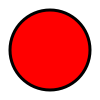

In [51]:
svg = """
    <svg height="100" width="100">
        <circle cx="50" cy="50" r="40" stroke="black" stroke-width="3" fill="red" >
        <title>Hello, World!</title>
        </circle>
    </svg> 
"""

class SVG:
    def _repr_svg_(self):
        return svg

class SVG2:
    def _repr_html_(self):
        return svg

display(SVG(), SVG2())